<a href="https://colab.research.google.com/github/vhousos/EKPA/blob/main/Anomaly_Detection_IForest_ECOD_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#εγκατάσταση πακέτου PyOD (https://pyod.readthedocs.io/en/latest/)
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 7.4 MB/s eta 0:00:00


In [2]:
#εισαγωγή βιβλιοθηκών - πακέτων
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pyod.models.iforest import IForest
import matplotlib.pyplot as plt

In [3]:
#εισαγωγή του συνόλου δεδομένων
network_data = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/network_traffic_data.csv', delimiter=',')

In [5]:
#εξαγωγή χαρακτηριστικών (ανεξάρτητων μεταβλητών) για την αναγνώριση ανωμαλιών
features = ['src_port', 'dest_port', 'packet_size', 'num_packets',
            'flow_duration', 'bytes_transferred', 'packet_rate']

X = network_data[features].values

In [6]:
#κλιμάκωση δεδομένων
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
#χρήση αλγορίθμου Isolation Forest
model = IForest(contamination=0.02, random_state=42)
model.fit(X_scaled)

IForest(behaviour='old', bootstrap=False, contamination=0.02,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=42, verbose=0)

In [8]:
#πρόβλεψη βαθμού ανωμαλίας (anomaly score)
anomaly_scores = model.decision_function(X_scaled)

In [9]:
#προσθήκη βαθμού ανωμαλίας (anomaly score) στο σύνολο δεδομένων
network_data['anomaly_score'] = anomaly_scores

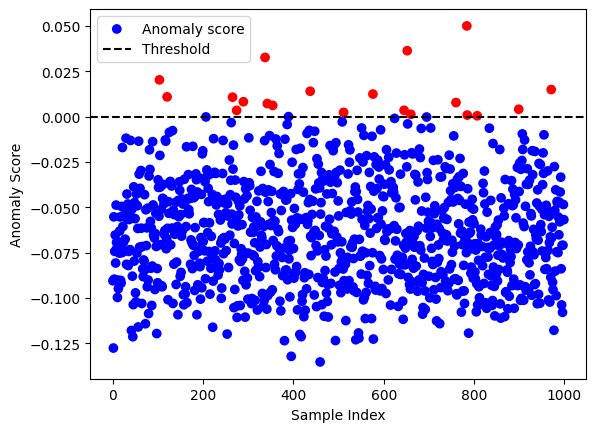

In [10]:

#οπτικοποίηση αποτελεσμάτων, με μπλε οι τιμές που θεωρούνται κανονικές και με κόκκινο όσες καταγράφονται ως ανωμαλίες
colors = ['blue' if score <= model.threshold_ else 'red' for score in anomaly_scores]

plt.scatter(network_data.index, anomaly_scores, c=colors, label='Anomaly score')
plt.axhline(y=model.threshold_, color='black', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()

In [11]:
#τύπωση των τιμών που εντοπίσθηκαν ως ανωμαλίες
anomalies = network_data[network_data['anomaly_score'] > model.threshold_]
print("Detected Anomalies:")
print(anomalies)

Detected Anomalies:
              src_ip          dest_ip  src_port  dest_port protocol  \
103    89.145.197.36    18.163.186.62     65172      62054      UDP   
120      99.1.205.76     53.87.67.219      2323       6690      UDP   
265     71.88.45.195    20.171.132.86     19691      60436      UDP   
274  124.101.237.131     42.206.11.39     14464      63598     ICMP   
289   153.152.11.132   211.36.233.208     63538       3010      UDP   
337    96.163.130.72  159.186.229.190      9670      10496      TCP   
342    148.7.229.199    199.246.71.61     13841      31790      UDP   
354     211.2.143.29   142.204.16.151     61037      12377     ICMP   
437   151.16.132.147  122.199.190.191     44814       2105     ICMP   
511   227.93.182.112     115.47.225.9     58564       2318      TCP   
576    232.167.57.27     165.27.24.95     57598       2156      TCP   
645  250.123.118.120     154.10.37.97      4515      61776     ICMP   
652    186.77.221.40  152.139.153.101     59121      6355

In [12]:

# Εκπαίδευση αλγορίθμου ECOD (Empirical Cumulative Distribution Outlier Detection)
from pyod.models.ecod import ECOD

model_ecod = ECOD()
model_ecod.fit(X_scaled)

# Υπολογισμός βαθμών ανωμαλίας (anomaly scores)
anomaly_scores_ecod = model_ecod.decision_function(X_scaled)

# Προσθήκη των αποτελεσμάτων ECOD στο dataframe
network_data['anomaly_score_ecod'] = anomaly_scores_ecod
print("Ο αλγόριθμος ECOD ολοκληρώθηκε επιτυχώς.")


Ο αλγόριθμος ECOD ολοκληρώθηκε επιτυχώς.


In [13]:

# Σύγκριση αποτελεσμάτων μεταξύ IForest και ECOD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Δημιουργούμε ετικέτες (0 = κανονικό, 1 = ανωμαλία)
labels_iforest = model.labels_
labels_ecod = model_ecod.labels_

# Υπολογίζουμε μετρικές συμφωνίας (χρησιμοποιώντας dummy ground truth για σύγκριση συνέπειας)
results = {'Classifier': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for clf_name, y_pred in [('IForest', labels_iforest), ('ECOD', labels_ecod)]:
    y_true = (y_pred == 0).astype(int)  # dummy "ground truth"
    acc = accuracy_score(y_true, (y_pred == 0).astype(int))
    precision = precision_score(y_true, (y_pred == 0).astype(int), average='weighted', zero_division=0)
    recall = recall_score(y_true, (y_pred == 0).astype(int), average='weighted', zero_division=0)
    f1 = f1_score(y_true, (y_pred == 0).astype(int), average='weighted', zero_division=0)

    results['Classifier'].append(clf_name)
    results['Accuracy'].append(acc)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)

results_df = pd.DataFrame(results)
print("\nΣύγκριση αλγορίθμων IForest και ECOD:")
print(results_df)



Σύγκριση αλγορίθμων IForest και ECOD:
  Classifier  Accuracy  Precision  Recall  F1 Score
0    IForest       1.0        1.0     1.0       1.0
1       ECOD       1.0        1.0     1.0       1.0
